In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from utils import load_log

log_file = '../../submissions/round2/trader_jm_xf_make_round2_final.log'
activity_log, trade_history, observation = load_log(log_file)

market_trades = trade_history[(trade_history.buyer == '') & (trade_history.seller == '')]
own_trades = trade_history[(trade_history.buyer == 'SUBMISSION') | (trade_history.seller == 'SUBMISSION')]

trade_ORCHIDS = own_trades[own_trades['symbol'] == 'ORCHIDS'].set_index('timestamp')
activity_ORCHIDS = activity_log[activity_log['product'] == 'ORCHIDS'].set_index('timestamp')

d:\Projects\Prosperity-Trader\JM\analysis\utils.py:44: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


In [3]:
observation = pd.read_csv('../../submissions/round2/observation_from_round2_result.csv')
observation = observation.set_index('timestamp').reindex(activity_ORCHIDS.index)
observation

,ASK,BID,TRANSPORT_FEES,EXPORT_TARIFF,IMPORT_TARIFF,SUNLIGHT,HUMIDITY,ORCHIDS
timestamp,,,,,,,,
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
100,1054.0,1055.5,1.0,8.0,-2.0,1100.8351,75.024070,1054.75
200,1054.0,1055.5,1.0,8.0,-2.0,1101.6697,75.048004,1054.75
300,1054.5,1056.0,1.0,8.0,-2.0,1102.5039,75.071810,1055.25
400,1055.5,1057.0,1.0,8.0,-2.0,1103.3376,75.095474,1056.25
...,...,...,...,...,...,...,...,...
999500,1051.0,1053.0,0.8,8.0,-4.0,2597.2483,69.917725,1052.00
999600,1050.5,1051.5,0.8,8.0,-4.0,2597.7950,69.934050,1051.00
999700,1051.0,1052.5,0.8,8.0,-4.0,2598.3435,69.950450,1051.75


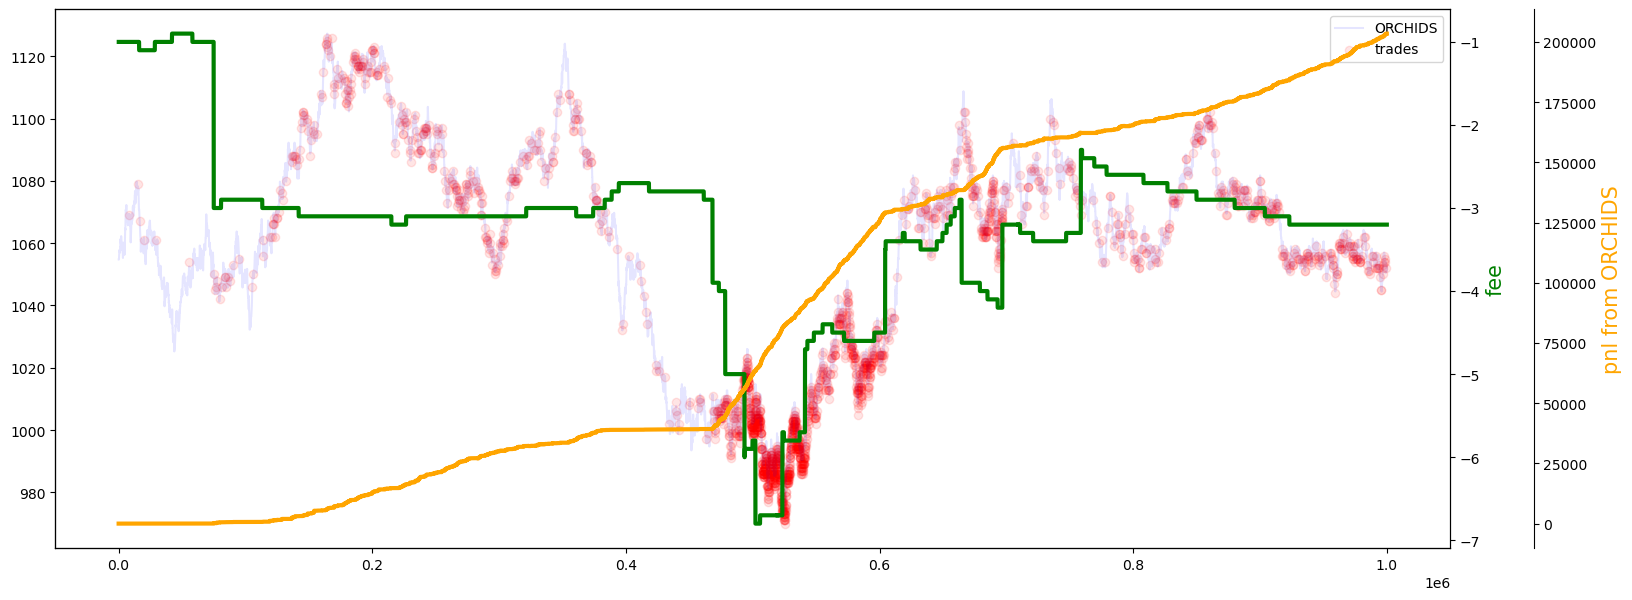

In [4]:
fee = observation['TRANSPORT_FEES'] + observation['IMPORT_TARIFF']
pnl = activity_ORCHIDS['profit_and_loss']
price = observation['ORCHIDS']

fig, ax = plt.subplots(figsize=(18, 7))
ax2 = ax.twinx()
ax3 = ax.twinx()
ax3.spines['right'].set_position(('outward', 60))
assert isinstance(ax, plt.Axes)
assert isinstance(ax2, plt.Axes)
assert isinstance(ax3, plt.Axes)

ax.plot(price , label='ORCHIDS', color='blue', alpha=0.1)
ax.scatter(trade_ORCHIDS.index, trade_ORCHIDS['price'], label='trades', color='red', alpha=0.1)
ax.legend()
ax2.plot(fee, label='fee', color='green', linewidth=3)
ax2.set_ylabel('fee', fontsize=15, color='green')
ax3.plot(pnl, label='pnl', color='orange', linewidth=3)
ax3.set_ylabel('pnl from ORCHIDS', fontsize=15, color='orange')
plt.show()

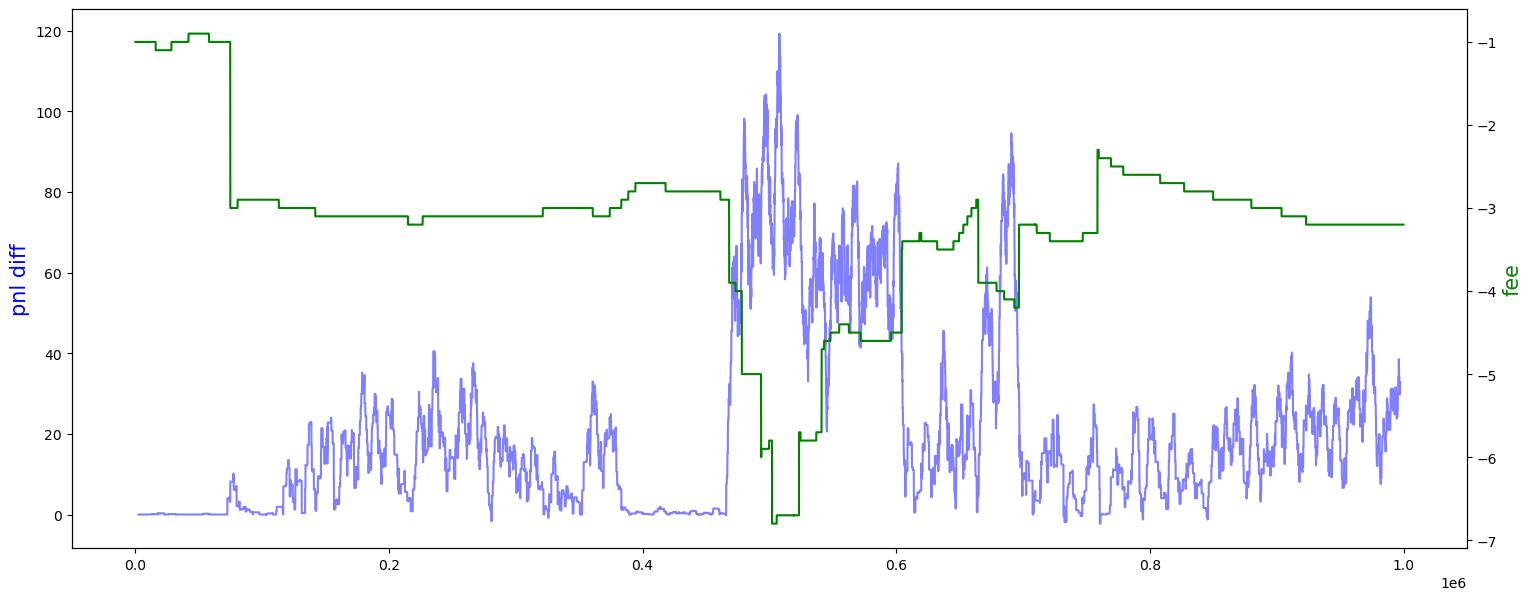

In [5]:
pnl_diff = pnl.diff().rolling(50, center=True).mean()

fig, ax = plt.subplots(figsize=(18, 7))
ax2 = ax.twinx()
assert isinstance(ax, plt.Axes)
assert isinstance(ax2, plt.Axes)

ax.plot(pnl_diff, label='pnl diff', color='blue', alpha=0.5)
ax.set_ylabel('pnl diff', fontsize=15, color='blue')
ax2.plot(fee, label='fee', color='green')
ax2.set_ylabel('fee', fontsize=15, color='green')
plt.show()

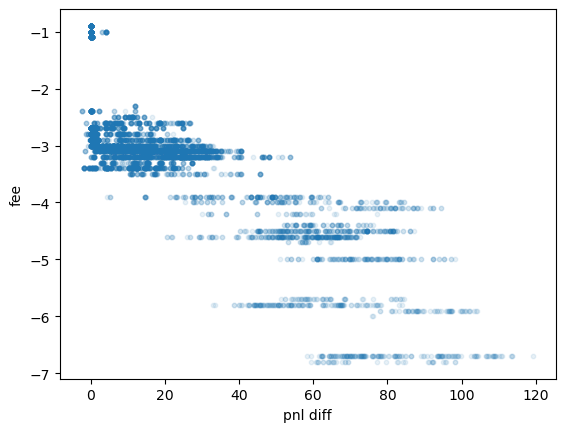

In [6]:
plt.scatter(pnl_diff, fee, s=10, alpha=0.1)
plt.xlabel('pnl diff')
plt.ylabel('fee')
plt.show()

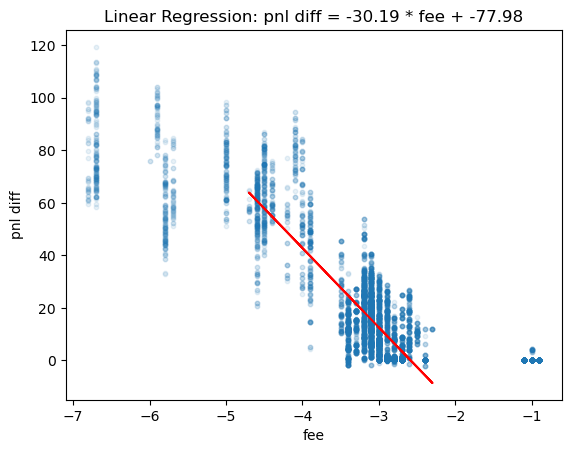

In [7]:
mask = (fee < -2) & (fee > -5)

pnl_diff_truc = pnl_diff[mask].dropna()
fee_truc = fee[mask].dropna()
common_index = pnl_diff_truc.index.intersection(fee_truc.index)
pnl_diff_truc = pnl_diff_truc.loc[common_index].values.reshape(-1, 1)
fee_truc = fee_truc.loc[common_index].values.reshape(-1, 1)

# do a linear regression
reg = LinearRegression().fit(fee_truc, pnl_diff_truc)

plt.scatter(fee, pnl_diff, s=10, alpha=0.1)
plt.plot(fee_truc, reg.predict(fee_truc), color='red')
plt.title('Linear Regression: pnl diff = %.2f * fee + %.2f' % (reg.coef_[0][0], reg.intercept_[0]))
plt.xlabel('fee')
plt.ylabel('pnl diff')
plt.show()

In [7]:
# r square
r2_score(pnl_diff_truc, reg.predict(fee_truc))

0.6510919275227008

### Spread = -4

d:\Projects\Prosperity-Trader\JM\analysis\utils.py:44: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


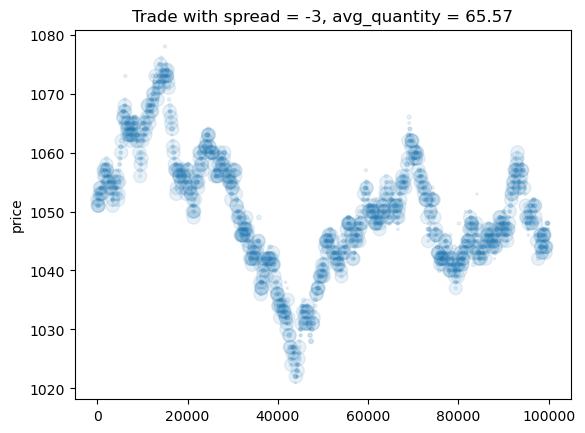

In [45]:
log_spread_4 = '../round3/test/ORCHIDS_test_spread=-4.log'
activity_log_spread_4, trade_history_spread_4, observation_spread_4 = load_log(log_spread_4)

own_trades_spread_4 = trade_history_spread_4[(trade_history_spread_4.buyer == 'SUBMISSION') | (trade_history_spread_4.seller == 'SUBMISSION')]
trade_ORCHIDS_spread_4 = own_trades_spread_4[own_trades_spread_4['symbol'] == 'ORCHIDS'].set_index('timestamp')

plt.scatter(trade_ORCHIDS_spread_4.index, trade_ORCHIDS_spread_4['price'], s=1* trade_ORCHIDS_spread_4['quantity'], alpha=0.1)
plt.ylabel('price')
plt.title(f'Trade with spread = -4, avg_quantity = {trade_ORCHIDS_spread_4['quantity'].sum()/1000}')
plt.show()

### Spread = -3

d:\Projects\Prosperity-Trader\JM\analysis\utils.py:44: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


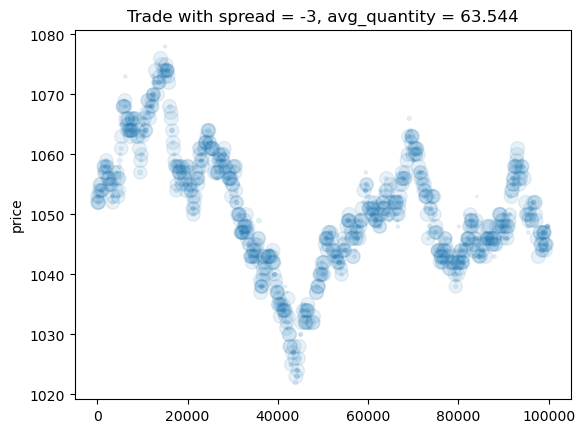

In [36]:
log_spread_3 = '../round3/test/ORCHIDS_test_spread=-3.log'
activity_log_spread_3, trade_history_spread_3, observation_spread_3 = load_log(log_spread_3)

own_trades_spread_3 = trade_history_spread_3[(trade_history_spread_3.buyer == 'SUBMISSION') | (trade_history_spread_3.seller == 'SUBMISSION')]
trade_ORCHIDS_spread_3 = own_trades_spread_3[own_trades_spread_3['symbol'] == 'ORCHIDS'].set_index('timestamp')

plt.scatter(trade_ORCHIDS_spread_3.index, trade_ORCHIDS_spread_3['price'], s=1* trade_ORCHIDS_spread_3['quantity'], alpha=0.1)
plt.ylabel('price')
plt.title(f'Trade with spread = -3, avg_quantity = {trade_ORCHIDS_spread_3['quantity'].sum()/1000}')
plt.show()

### Spread = -2

d:\Projects\Prosperity-Trader\JM\analysis\utils.py:44: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


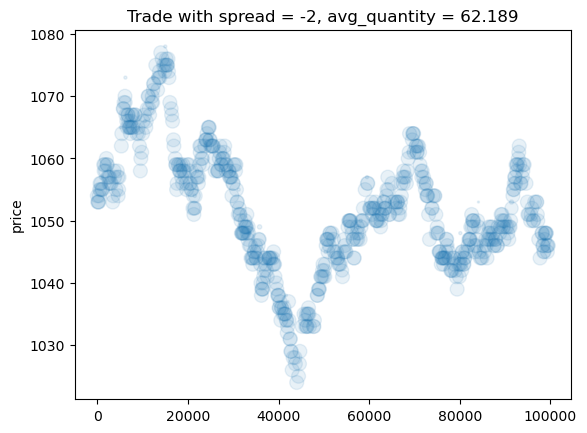

In [37]:
log_spread_2 = '../round3/test/ORCHIDS_test_spread=-2.log'
activity_log_spread_2, trade_history_spread_2, observation_spread_2 = load_log(log_spread_2)

own_trades_spread_2 = trade_history_spread_2[(trade_history_spread_2.buyer == 'SUBMISSION') | (trade_history_spread_2.seller == 'SUBMISSION')]
trade_ORCHIDS_spread_2 = own_trades_spread_2[own_trades_spread_2['symbol'] == 'ORCHIDS'].set_index('timestamp')

plt.scatter(trade_ORCHIDS_spread_2.index, trade_ORCHIDS_spread_2['price'], s=1* trade_ORCHIDS_spread_2['quantity'], alpha=0.1)
plt.ylabel('price')
plt.title(f'Trade with spread = -2, avg_quantity = {trade_ORCHIDS_spread_2['quantity'].sum()/1000}')
plt.show()

### Spread = -1

d:\Projects\Prosperity-Trader\JM\analysis\utils.py:44: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


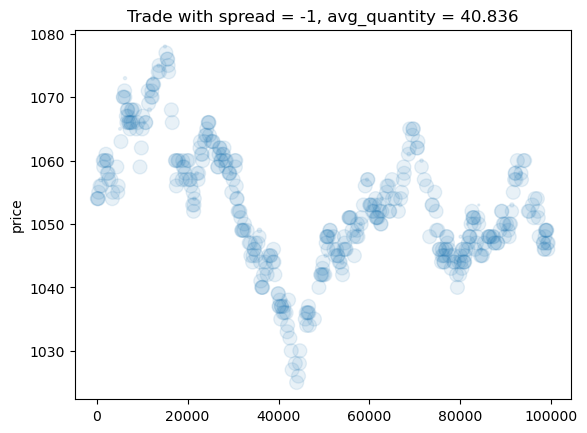

In [38]:
log_spread_1 = '../round3/test/ORCHIDS_test_spread=-1.log'
activity_log_spread_1, trade_history_spread_1, observation_spread_1 = load_log(log_spread_1)

own_trades_spread_1 = trade_history_spread_1[(trade_history_spread_1.buyer == 'SUBMISSION') | (trade_history_spread_1.seller == 'SUBMISSION')]
trade_ORCHIDS_spread_1 = own_trades_spread_1[own_trades_spread_1['symbol'] == 'ORCHIDS'].set_index('timestamp')

plt.scatter(trade_ORCHIDS_spread_1.index, trade_ORCHIDS_spread_1['price'], s=1* trade_ORCHIDS_spread_1['quantity'], alpha=0.1)
plt.ylabel('price')
plt.title(f'Trade with spread = -1, avg_quantity = {trade_ORCHIDS_spread_1['quantity'].sum()/1000}')
plt.show()

### Spread = 0

d:\Projects\Prosperity-Trader\JM\analysis\utils.py:44: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


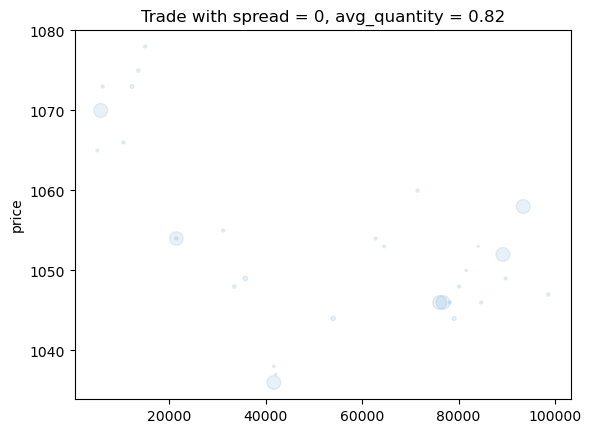

In [42]:
log_spread_0 = '../round3/test/ORCHIDS_test_spread=0.log'
activity_log_spread_0, trade_history_spread_0, observation_spread_0 = load_log(log_spread_0)

own_trades_spread_0 = trade_history_spread_0[(trade_history_spread_0.buyer == 'SUBMISSION') | (trade_history_spread_0.seller == 'SUBMISSION')]
trade_ORCHIDS_spread_0 = own_trades_spread_0[own_trades_spread_0['symbol'] == 'ORCHIDS'].set_index('timestamp')

plt.scatter(trade_ORCHIDS_spread_0.index, trade_ORCHIDS_spread_0['price'], s=1* trade_ORCHIDS_spread_0['quantity'], alpha=0.1)
plt.ylabel('price')
plt.title(f'Trade with spread = 0, avg_quantity = {trade_ORCHIDS_spread_0['quantity'].sum()/1000}')
plt.show()

### Spread = -0.5

d:\Projects\Prosperity-Trader\JM\analysis\utils.py:44: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  trade_history = pd.read_json(trade_history)


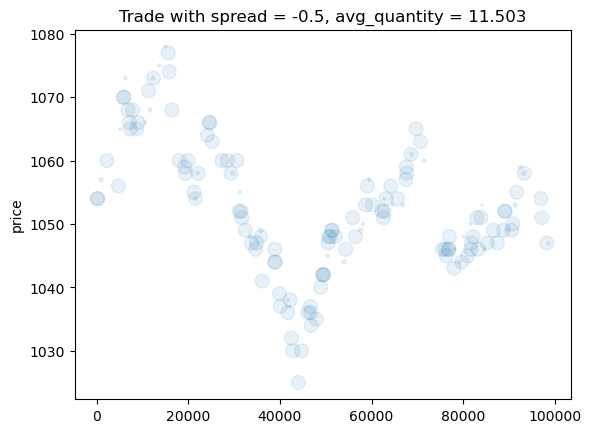

In [43]:
log_spread_05 = '../round3/test/ORCHIDS_test_spread=0.5.log'
activity_log_spread_05, trade_history_spread_05, observation_spread_05 = load_log(log_spread_05)

own_trades_spread_05 = trade_history_spread_05[(trade_history_spread_05.buyer == 'SUBMISSION') | (trade_history_spread_05.seller == 'SUBMISSION')]
trade_ORCHIDS_spread_05 = own_trades_spread_05[own_trades_spread_05['symbol'] == 'ORCHIDS'].set_index('timestamp')

plt.scatter(trade_ORCHIDS_spread_05.index, trade_ORCHIDS_spread_05['price'], s=1* trade_ORCHIDS_spread_05['quantity'], alpha=0.1)
plt.ylabel('price')
plt.title(f'Trade with spread = -0.5, avg_quantity = {trade_ORCHIDS_spread_05['quantity'].sum()/1000}')
plt.show()

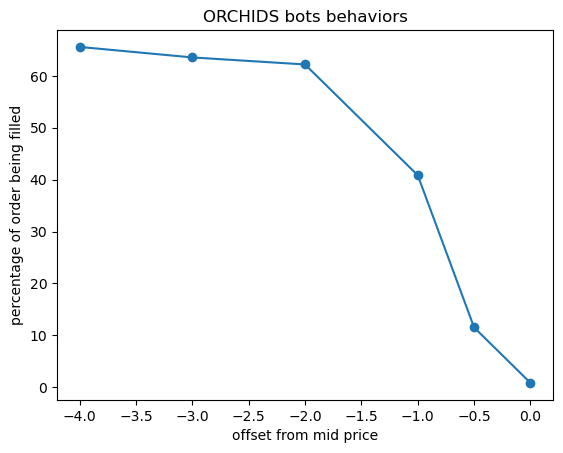

In [50]:
vol = pd.Series(index=[-4, -3, -2, -1, -0.5, 0])
vol[-4] = trade_ORCHIDS_spread_4['quantity'].sum()/1000
vol[-3] = trade_ORCHIDS_spread_3['quantity'].sum()/1000
vol[-2] = trade_ORCHIDS_spread_2['quantity'].sum()/1000
vol[-1] = trade_ORCHIDS_spread_1['quantity'].sum()/1000
vol[0] = trade_ORCHIDS_spread_0['quantity'].sum()/1000
vol[-0.5] = trade_ORCHIDS_spread_05['quantity'].sum()/1000

plt.plot(vol, marker='o')
plt.ylabel('percentage of order being filled')
plt.xlabel('offset from mid price')
plt.title('ORCHIDS bots behaviors')
plt.show()